In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.neural_network import MLPRegressor
import warnings as wn
wn.filterwarnings('ignore')

In [2]:
# Dataset Review
file_path = "/kaggle/input/dataset/QV_analysis_dataset/QV1_analysis.csv"
df = pd.read_csv(file_path)
df.head(10)

,Somme,Valeur suivante
0,0,2.0
1,2,9.0
2,11,-13.0
3,-2,4.0
4,2,12.0
5,14,-6.0
6,8,-6.0
7,2,2.0
8,4,13.0
9,17,-16.0


In [3]:
def create_sequence_of_first_5_points(df, column, column_names = 'point',window_size=5):
    values = df[column].values
    
    # Initialize lists to store the feature rows and targets
    features = []
    targets = []
    columns = []

    # Loop through the values, taking 5 values as features and the 6th as the target
    for i in range(len(values) - window_size):
        feature_row = values[i:i+window_size]
        target = values[i+window_size]
        
        # Append the feature row and target to the respective lists
        features.append(feature_row)
        targets.append(target)

    for i in range(window_size):
        col = f"{column_names} {i+1}"
        columns.append(col)
        
    # Create a new DataFrame from the feature rows and targets
    new_df = pd.DataFrame(features, columns=columns)
    new_df[f'{column_names} 6th'] = targets
    
    return new_df

In [4]:

def sequence_into_window(dataset_path):
    """
    Function to convert a series of points into a sequence of windows of size five.
    
    Parameters:
    dataset_path (str): Path to the dataset CSV file.

    Returns:
    series_dataset (DataFrame): The main dataset with sequences of the first 5 points.
    last_row (DataFrame): The last row of the dataset for further analysis.
    """
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(dataset_path)
    
    # Create a sequence of the first 5 points for the 'Valeur suivante' column
    next_value_dataset = create_sequence_of_first_5_points(
        df=df,
        column='Valeur suivante',
        window_size=5
    )
    
    # Create a sequence of the first 5 points for the 'Somme' column
    sum_dataset = create_sequence_of_first_5_points(
        df=df,
        column='Somme',
        window_size=5,
        column_names='Somme'
    )
    
    # Concatenate the two datasets along columns
    series_dataset = pd.concat((sum_dataset, next_value_dataset), axis=1, ignore_index=True)
    
    # Get the last row of the concatenated dataset
    last_row = series_dataset.tail(1)
    
    # Remove the last row from the main dataset
    series_dataset = series_dataset.head(len(series_dataset)-1)
    
    return series_dataset, last_row


# Split Dataset

In [5]:
# Function for split the dataset into Test and train.
def split_dataset(final_dataset):
    x = final_dataset.drop(11,axis=1)
    y = final_dataset[11]
    x_train,x_test,y_train,y_test =  train_test_split(
        x,y,
        test_size=0.003,
        shuffle=False
    )
    return x,y,x_test,y_test

# Evaluate Best Model

In [6]:
def evaluate_models(x_test, y_test, models):
    """
    Evaluate multiple regression models on test data, plot their predictions, 
    and return the model with the lowest MSE score.
    
    Parameters:
    x_test (DataFrame or ndarray): Feature data for testing.
    y_test (Series or ndarray): Target data for testing.
    models (dict): A dictionary of trained models.
    
    Returns:
    best_model (sklearn model): The model with the lowest MSE score.
    """
    
    y_test = np.array(y_test)
    
    # Initialize dictionary to store predictions and MSEs
    predictions = {}
    mses = {}
    
    # Iterate over models to make predictions and calculate MSE
    for name, model in models.items():
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        predictions[name] = y_pred
        mses[name] = mse
    
    # Find the model with the lowest MSE
    best_model_name = min(mses, key=mses.get)
    best_model = models[best_model_name]
    
    sns.set_style('whitegrid')
    plt.figure(figsize=(13, 10))
    
    # Plot the actual vs predicted values for each model
    for i, (name, y_pred) in enumerate(predictions.items(), 1):
        plt.subplot(3, 2, i)
        plt.plot(y_test, label='Actual', color='black', marker='o')
        plt.plot(y_pred, label='Predicted',color='tomato', marker='o')
        plt.title(f'{name} \nError(MSE): {np.round(mses[name],decimals=3)}')
        plt.xlabel('Sample')
        plt.ylabel('Target')
        plt.legend()
    
    # Adjust layout to make room for all subplots
    plt.tight_layout()
    plt.show()
    
    return best_model

In [7]:
def add_calculated_value(best_model, last_row, original_dataset_path, new_file_save_path):
    """
    Function to add calculated values to the original dataset.
    
    Parameters:
    last_row (DataFrame): The last row of the series dataset.
    original_dataset_path (str): Path to the original dataset CSV file.
    new_file_save_path (str): Path where the new dataset will be saved.

    Returns:
    df (DataFrame): The updated DataFrame with the calculated values.
    """
    
    # Read the original dataset into a DataFrame
    df = pd.read_csv(original_dataset_path)
    
    # Prepare the data for prediction by dropping the last column
    next_val = last_row.drop(11, axis=1)
    
    # Predict the next value using the model and round it
    pred_next_val = np.round(best_model.predict(next_val)[0])
    print("Calculated Next Value: ", pred_next_val)
    
    # Fill any NaN values in the DataFrame with the predicted value
    df.fillna(pred_next_val, inplace=True)
    
    # Calculate the next sum by adding the last 'Somme' and 'Valeur suivante' values
    Sum = np.array(df.iloc[len(df)-1:len(df)]['Somme'] + df.iloc[len(df)-1:len(df)]['Valeur suivante'])[0]
    print("Calculated Next Sum: ", Sum)
    
    # Create a new row with the calculated sum and a placeholder for 'Valeur suivante'
    val = {'Somme': Sum, 'Valeur suivante': None}
    
    # Append the new row to the DataFrame
    df.loc[len(df)] = val
    
    # Save the updated DataFrame to a new CSV file
    df.to_csv(new_file_save_path, index=False)
    
    return df

In [8]:
def calculate_result(csv_file_path,csv_result_file_save_path):
    
    """
    Train multiple regression models on the provided data.
    
    Parameters:
    x (DataFrame or ndarray): Feature data for training.
    y (Series or ndarray): Target data for training.
    
    Returns:
    dict: A dictionary containing the trained models.
    """
    final_dataset, last_row = sequence_into_window(dataset_path=csv_file_path)
    x,y,x_test,y_test = split_dataset(final_dataset)
    
    # Initialize models
    model1 = AdaBoostRegressor()
    model2 = RandomForestRegressor()
    model3 = LinearRegression()
    model4 = XGBRegressor(
        n_estimators=500,       # Reduced to prevent overfitting
        max_depth=6,            # Slightly reduced to prevent overfitting
        learning_rate=0.05,     # Reduced to improve robustness
        subsample=0.8,          # Increased slightly to use more data
        colsample_bytree=0.8,   # Kept the same for feature sampling
        gamma=0.1,              # Added to prevent overfitting
        min_child_weight=5,     # Increased to make the model more conservative
        reg_lambda=1,           # L2 regularization term
        reg_alpha=0.5           # L1 regularization term
    )
    model5 = LGBMRegressor(verbose=0)
    model6 = GradientBoostingRegressor()
    
    # Train models
    model1.fit(x, y)
    model2.fit(x, y)
    model3.fit(x, y)
    model4.fit(x, y)
    model5.fit(x, y)
    model6.fit(x, y)
    
    # Store models in a dictionary
    models = {
        'AdaBoostRegressor': model1,
        'RandomForestRegressor': model2,
        'LinearRegression': model3,
        'XGBRegressor': model4,
        'LGBMRegressor': model5,
        'GradientBoostingRegressor': model6
    }
    
    best_model = evaluate_models(x_test,y_test,models)
    result_file = add_calculated_value(
        best_model=best_model,
        last_row=last_row,
        original_dataset_path=csv_file_path,
        new_file_save_path=csv_result_file_save_path
    )
    return result_file

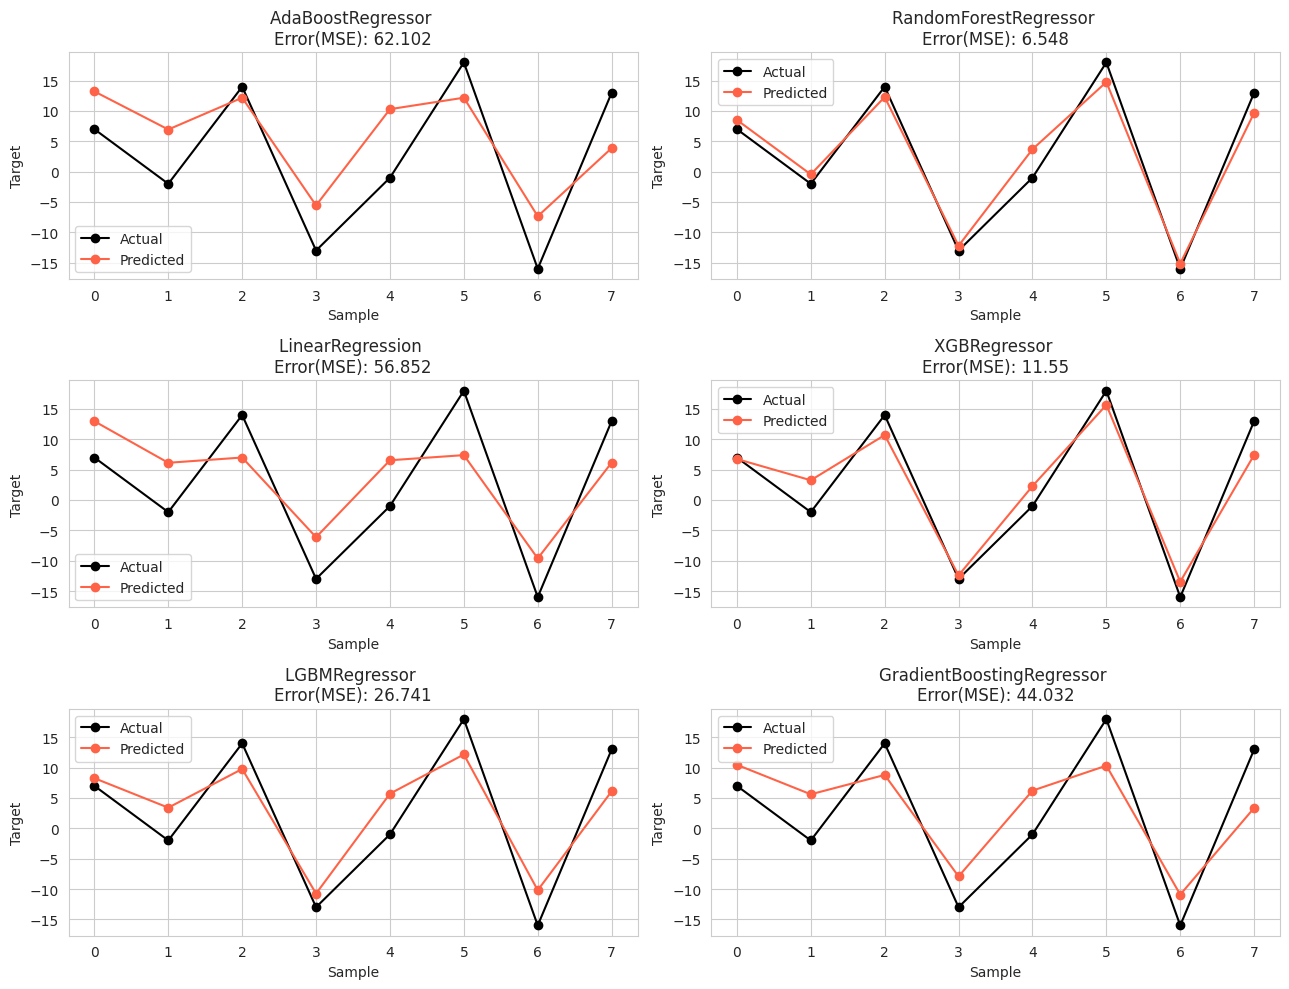

Calculated Next Value:  -9.0
Calculated Next Sum:  -24.0


,Somme,Valeur suivante
0,0.0,0.0
1,0.0,-2.0
2,-2.0,-8.0
3,-10.0,-10.0
4,-20.0,6.0
...,...,...
2504,-30.0,18.0
2505,-12.0,-16.0
2506,-28.0,13.0
2507,-15.0,-9.0


In [9]:
file_path = "/kaggle/input/dataset/QV_analysis_dataset/QVP_analysis.csv"
save_path = '/kaggle/working/Calculated_QVP.csv'
calculate_result(
    csv_file_path=file_path,
    csv_result_file_save_path=save_path
)